In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download dataset from KaggleHub
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Testing")

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
# Load datasets
trainval_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = trainval_dataset.classes

In [6]:
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Split train into train/val
val_size = int(0.15 * len(trainval_dataset))
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [ ]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # ---------- Logging ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Save best model ----------
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_brain_tumor_{name}.pth")
            early_stop_counter = 0  # reset if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

        # ---------- Early stopping ----------
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history


In [ ]:
# Testing function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


In [ ]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1)
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # Unnormalize

                ax.imshow(img)
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
                ax.axis('off')

                images_shown += 1

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [ ]:
# Load pretrained ResNet18
model2 = models.resnet18(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Modify classifier
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)
model2 = model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [ ]:
# First phase training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet18')

Epoch [1/60] Train Loss: 0.6014, Train Acc: 0.7634 Val Loss: 0.3331, Val Acc: 0.8879
Epoch [2/60] Train Loss: 0.4223, Train Acc: 0.8421 Val Loss: 0.3023, Val Acc: 0.8902
Epoch [3/60] Train Loss: 0.3442, Train Acc: 0.8756 Val Loss: 0.2480, Val Acc: 0.9054
Epoch [4/60] Train Loss: 0.3359, Train Acc: 0.8738 Val Loss: 0.2297, Val Acc: 0.9229
Epoch [5/60] Train Loss: 0.3079, Train Acc: 0.8857 Val Loss: 0.2686, Val Acc: 0.8984
No improvement in validation loss for 1 epoch(s).
Epoch [6/60] Train Loss: 0.2780, Train Acc: 0.8927 Val Loss: 0.2318, Val Acc: 0.9089
No improvement in validation loss for 2 epoch(s).
Epoch [7/60] Train Loss: 0.2817, Train Acc: 0.8925 Val Loss: 0.2107, Val Acc: 0.9264
Epoch [8/60] Train Loss: 0.2651, Train Acc: 0.9007 Val Loss: 0.1994, Val Acc: 0.9276
Epoch [9/60] Train Loss: 0.2444, Train Acc: 0.9100 Val Loss: 0.1992, Val Acc: 0.9299
Epoch [10/60] Train Loss: 0.2346, Train Acc: 0.9106 Val Loss: 0.1870, Val Acc: 0.9322
Epoch [11/60] Train Loss: 0.2273, Train Acc: 0.91

Test Accuracy: 0.9321


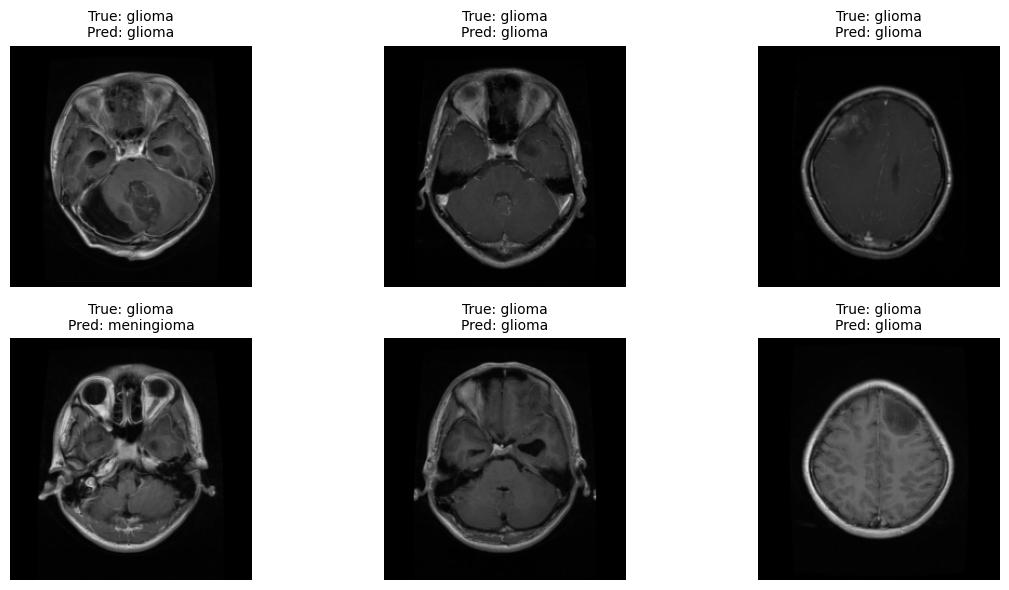

In [ ]:
# First test
model2.load_state_dict(torch.load("best_brain_tumor_resnet18.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Initial ResNet18 Model
              precision    recall  f1-score   support

      glioma       0.94      0.87      0.90       300
  meningioma       0.85      0.88      0.86       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



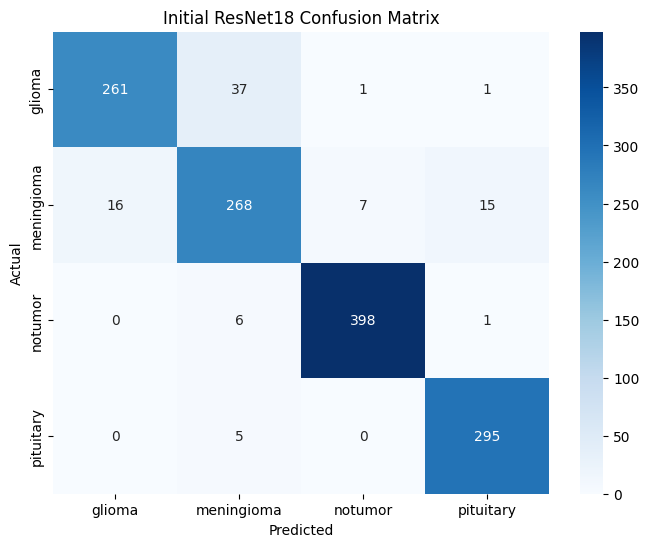

In [ ]:
print("\nEvaluation: Initial ResNet18 Model")
model2.load_state_dict(torch.load("best_brain_tumor_resnet18.pth"))
evaluate_model(model2, test_loader, class_names, title="Initial ResNet18 Confusion Matrix")


In [ ]:
# Fine-tuning
for name, param in model2.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet18_finetuned')

Epoch [1/60] Train Loss: 0.2110, Train Acc: 0.9279 Val Loss: 0.0985, Val Acc: 0.9696
Epoch [2/60] Train Loss: 0.0722, Train Acc: 0.9751 Val Loss: 0.1210, Val Acc: 0.9638
No improvement in validation loss for 1 epoch(s).
Epoch [3/60] Train Loss: 0.0409, Train Acc: 0.9868 Val Loss: 0.0458, Val Acc: 0.9825
Epoch [4/60] Train Loss: 0.0318, Train Acc: 0.9876 Val Loss: 0.1091, Val Acc: 0.9614
No improvement in validation loss for 1 epoch(s).
Epoch [5/60] Train Loss: 0.0383, Train Acc: 0.9874 Val Loss: 0.0789, Val Acc: 0.9813
No improvement in validation loss for 2 epoch(s).
Epoch [6/60] Train Loss: 0.0144, Train Acc: 0.9949 Val Loss: 0.0737, Val Acc: 0.9860
No improvement in validation loss for 3 epoch(s).
Epoch [7/60] Train Loss: 0.0276, Train Acc: 0.9920 Val Loss: 0.1097, Val Acc: 0.9766
No improvement in validation loss for 4 epoch(s).
Epoch [8/60] Train Loss: 0.0489, Train Acc: 0.9864 Val Loss: 0.0786, Val Acc: 0.9755
No improvement in validation loss for 5 epoch(s).
Early stopping trigg

Test Accuracy: 0.9771


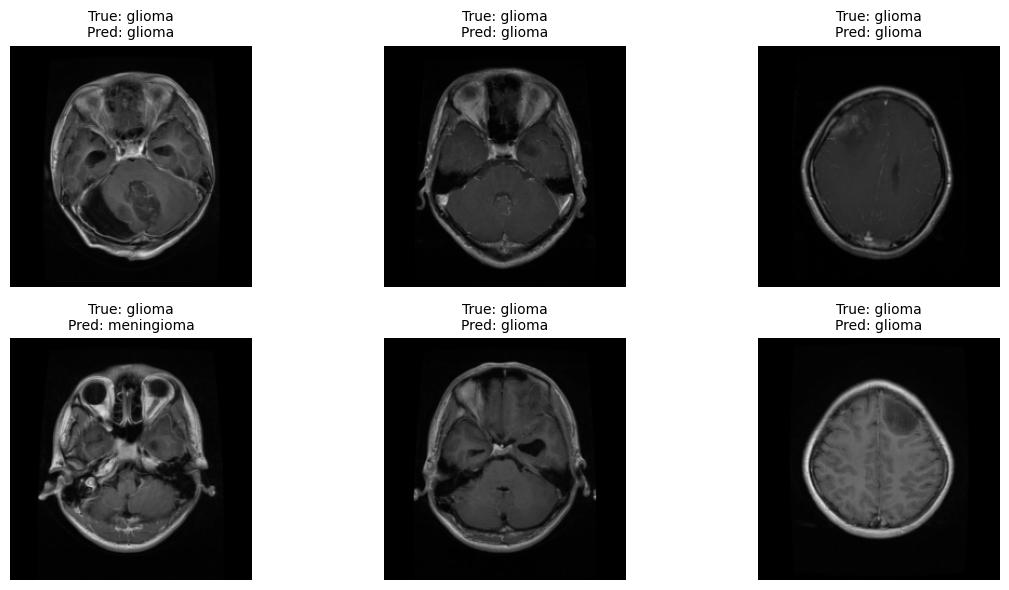

In [ ]:
# Final test
model2.load_state_dict(torch.load("best_brain_tumor_resnet18_finetuned.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Fine-tuned ResNet18 Model
              precision    recall  f1-score   support

      glioma       0.96      0.96      0.96       300
  meningioma       0.95      0.95      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



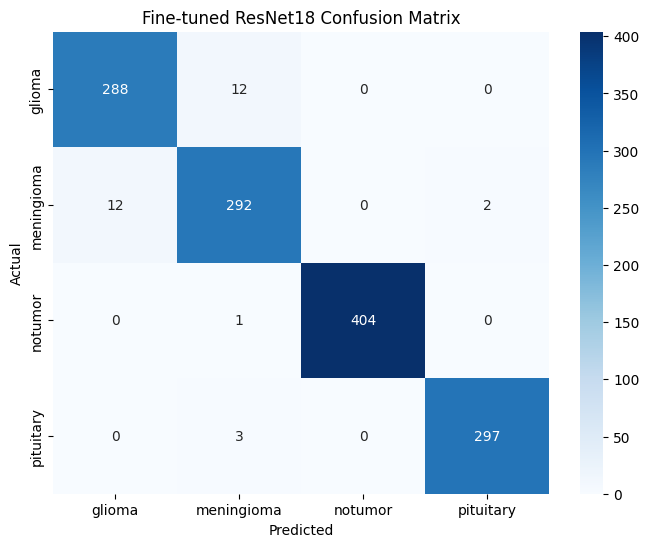

In [ ]:
print("\nEvaluation: Fine-tuned ResNet18 Model")
model2.load_state_dict(torch.load("best_brain_tumor_resnet18_finetuned.pth"))
evaluate_model(model2, test_loader, class_names, title="Fine-tuned ResNet18 Confusion Matrix")


Predicted Label: pituitary


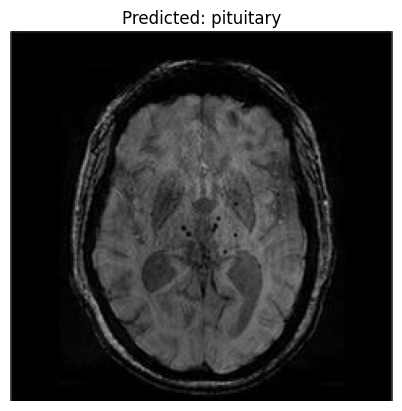

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # match training normalization
])
img_path = "Te-no_0026.jpg"  # your image file
image = Image.open(img_path).convert("RGB")  # convert in case it's grayscale
input_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension
model2.eval()
with torch.no_grad():
    output = model2(input_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_label = class_names[predicted_class.item()]
print(f"Predicted Label: {predicted_label}")
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


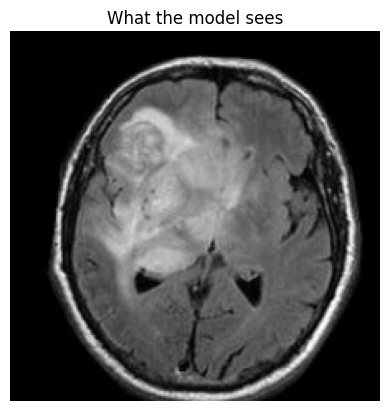

In [ ]:
unnorm = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
vis_tensor = unnorm(input_tensor[0].cpu()).clamp(0, 1)  # Undo normalization

plt.imshow(vis_tensor.permute(1, 2, 0))
plt.title("What the model sees")
plt.axis('off')
plt.show()


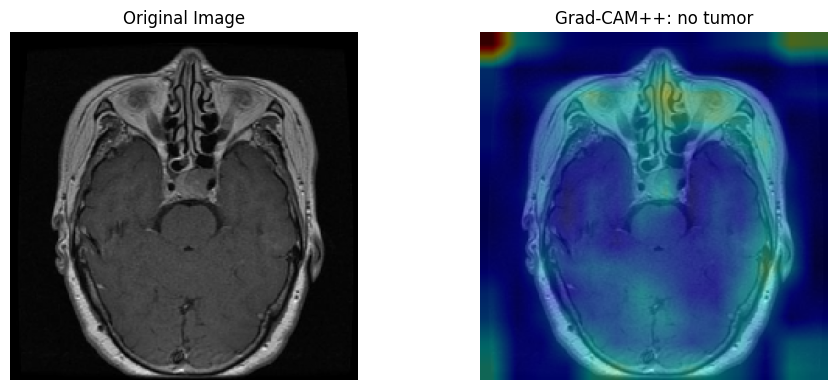

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

img_path = "Te-pi_0061.jpg"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Store gradients & activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
target_layer = model2.layer4  # Can be layer3, layer4 etc.
handle_fwd = target_layer.register_forward_hook(forward_hook)
handle_bwd = target_layer.register_full_backward_hook(backward_hook)

# Forward and backward
model2.eval()
output = model2(input_tensor)
pred_class = output.argmax(dim=1).item()

model2.zero_grad()
output[0, pred_class].backward(retain_graph=True)

# Get tensors
act = activations[0].detach().cpu()[0]  # [C, H, W]
grad = gradients[0].detach().cpu()[0]   # [C, H, W]

# Handle shape dynamically
C, H, W = act.shape
grad = grad.numpy()
act = act.numpy()

# Grad-CAM++ logic
grad2 = grad ** 2
grad3 = grad2 * grad

sum_grad2 = np.sum(grad2, axis=(1, 2), keepdims=True)
sum_grad3 = np.sum(grad3, axis=(1, 2), keepdims=True)

eps = 1e-8
alpha = grad2 / (2 * grad2 + sum_grad3 + eps)
weights = np.sum(alpha * np.maximum(grad, 0), axis=(1, 2))  # shape [C]

# Compute CAM with correct shapes
cam = np.zeros((H, W), dtype=np.float32)
for i in range(C):
    cam += weights[i] * act[i]

# Post-processing
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

# Overlay on original image
img_np = np.array(image.resize((224, 224))) / 255.0
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = (heatmap / 255.0) * 0.4 + img_np * 0.6

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM++: {class_names[pred_class]}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Remove hooks
handle_fwd.remove()
handle_bwd.remove()
